# Quantum Euclidean Distance for Two Images using Quantum Fourier Transform

In [35]:
#Notebook written by Miguel de Jesús Martínez Felipe and Divyanshu Singh 
# Quantum Euclidean Distance for Two Images using Quantum Fourier Transform
#https://github.com/Miguelillnino and https://github.com/divshacker

from qiskit import *
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy import pi
from qiskit.circuit.library import QFT

#Libraries for Image Processing 
import numpy as np
import cv2
import matplotlib.pyplot as plt

In this notebook we will calculate the Euclidean distance with the Quantum Fourier Transform rotatios and can be applied on a image processing, we can see an implementation for one pixel and for both images.

The topic of similarity/dissimilarity measure can help to solve problems in block matching, similarity meas. It is essential to find a group of similar image patches inside a search area. In different practical applications often is necessary to find groups of similar image blocks within an ample search area, The problem of image template location in a considered image is very common in different applications such as video compression, image clustering, vector quantization, nonlocal noise reduction; To match templates, various measures of similarity/dissimilarity can be applied.

Given two sequences of measurements $X = {xi : i = 1, . . . , n}$ and $Y = {yi : i = 1, . . . , n}$, the similarity (dissimilarity) between them is a measure that quantifies the dependency (independency) between the sequences. $X$ and $Y$ can represent measurements from two objects or phenomena. So, we assume they represent images and $x_i$ and $y_i$ are intensities of corresponding pixels in the images. If $X$ and $Y$ represent 2-D images, the sequences can be considered intensities in the images in raster-scan order.

A dissimilarity measure $D$ is considered a metric if it produces a higher value as corresponding values in $X$ and $Y$ become less dependent. A metric dissimilarity $D$ satisfies the following for all sequences $X$ and $Y$ [1]:

1. Nonnegativity: $D(X,Y) ≥ 0$.
2. Reflexivity: $D(X,Y) = 0$ if and only if $X = Y$ .
3. Symmetry: $D(X,Y) = D(Y,X)$.
4. Triangle Inequality: $D(X,Y) + D(Y,Z) ≥ D(X,Z)$.

## Square L2 Norm (Euclidean distance)
Square L2 norm, square Euclidean distance, or sum of squared intensity differences of corresponding pixels in sequences $X = {xi : i = 1, . . . , n}$ and $Y = {yi : i = 1, . . . , n}$ is defined by:

\begin{equation}
{L_2^2} = \sum_i^n ({x_i}-{y_i})^2
\end{equation}


## Quantum Fourier Transform

As explained in [2], the Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT) is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. It is part of many quantum algorithms, most notably Shor's factoring algorithm and quantum phase estimation.

The Quantum Fourier Transform (QFT) on qubits is the operation:
\begin{equation}
|j\rangle \mapsto \frac{1}{2^{n/2}} \sum_{k=0}^{2^n - 1} e^{2\pi ijk / 2^n} |k\rangle
\end{equation}

For 4 qubits, the circuit that implements this transformation is:

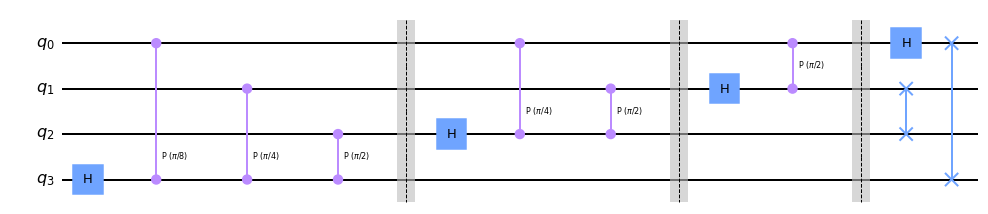

In [51]:
def QFT4qubits(qc):
    qc.h(3)
    qc.cp(pi/8, 0, 3)
    qc.cp(pi/4, 1, 3)
    qc.cp(pi/2, 2, 3)
    qc.barrier()
    qc.h(2)
    qc.cp(pi/4, 0, 2)
    qc.cp(pi/2, 1, 2)
    qc.barrier()
    qc.h(1)
    qc.cp(pi/2, 0, 1)
    qc.barrier()
    qc.h(0)
    qc.swap(0,3)
    qc.swap(1,2)
    
    return qc

qc = QuantumCircuit(4)
QFT4qubits(qc).draw('mpl')

We can see the result in the Fourier state $|˜0⟩$:

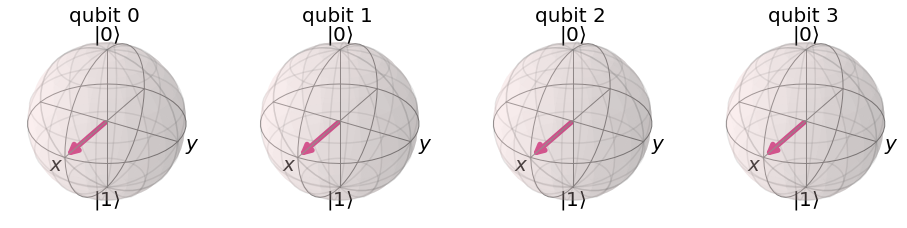

In [52]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(qc)


Adding X-Pauli gates in $q_0$ and $q_3$ for see results in number 9:

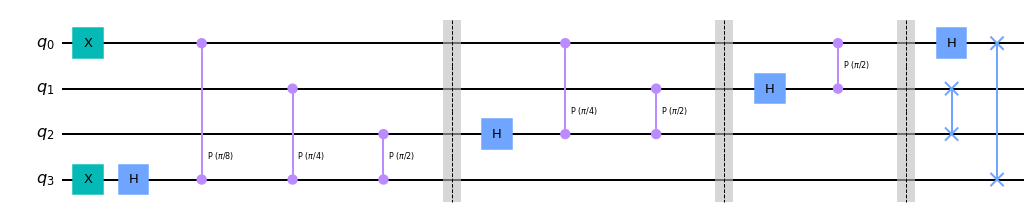

In [53]:
qc = QuantumCircuit(4)
qc.x(0)
qc.x(3)
QFT4qubits(qc).draw('mpl')

We can see the result in the Fourier state $|˜9⟩$:

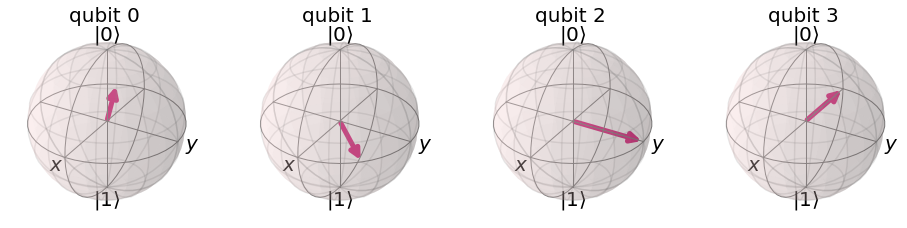

In [54]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(qc)

## Implementation:
For this first example, we need to code the right and left rotations, as we could see, we can perfomed rotations to the right with the QFT, so when we want to rotate some binary value to the left, so we need invert the sign (-) to the rotations.

In [2]:
def add_qubit(qc, q, sign = 1):
    if q > 3:
        sign = -sign
        
    for indx, qb in enumerate(range(8,12)):
        qc.cu1(sign * pi / (2**(3 - indx)), q, qb)
    

To represent one a pixel value, it is essential to use Four qubits for the first pixel image, so in this case 4-bit pixel it is a  range of [0,15]

In [3]:
# For 2 qubits per image
# firstPart = 3
# secondPart = 1
# secondPart = secondPart -2
# firstPart = firstPart - 2

# For 4 qubits per image
# firstPart = 5
# secondPart = 1

def rotationsFourier(qc, sign = 1):
    qc.append(QFT(4), range(8,12))
    qPrima = 0
#   firstPart y secondPart, number of rotations
    firstPart = 5
    secondPart = 1
    for q in range(0,8):
        if q > 3:
            secondPart = secondPart -2
            qPrima = q + secondPart
        else:
            firstPart = firstPart - 2
            qPrima = q + firstPart
#         print(q)
        for index in range(0,2**qPrima):
            add_qubit(qc, q, sign)
            qc.barrier()
   
    qc.append(QFT(4,inverse=True), range(8,12)) #invQFT(4)

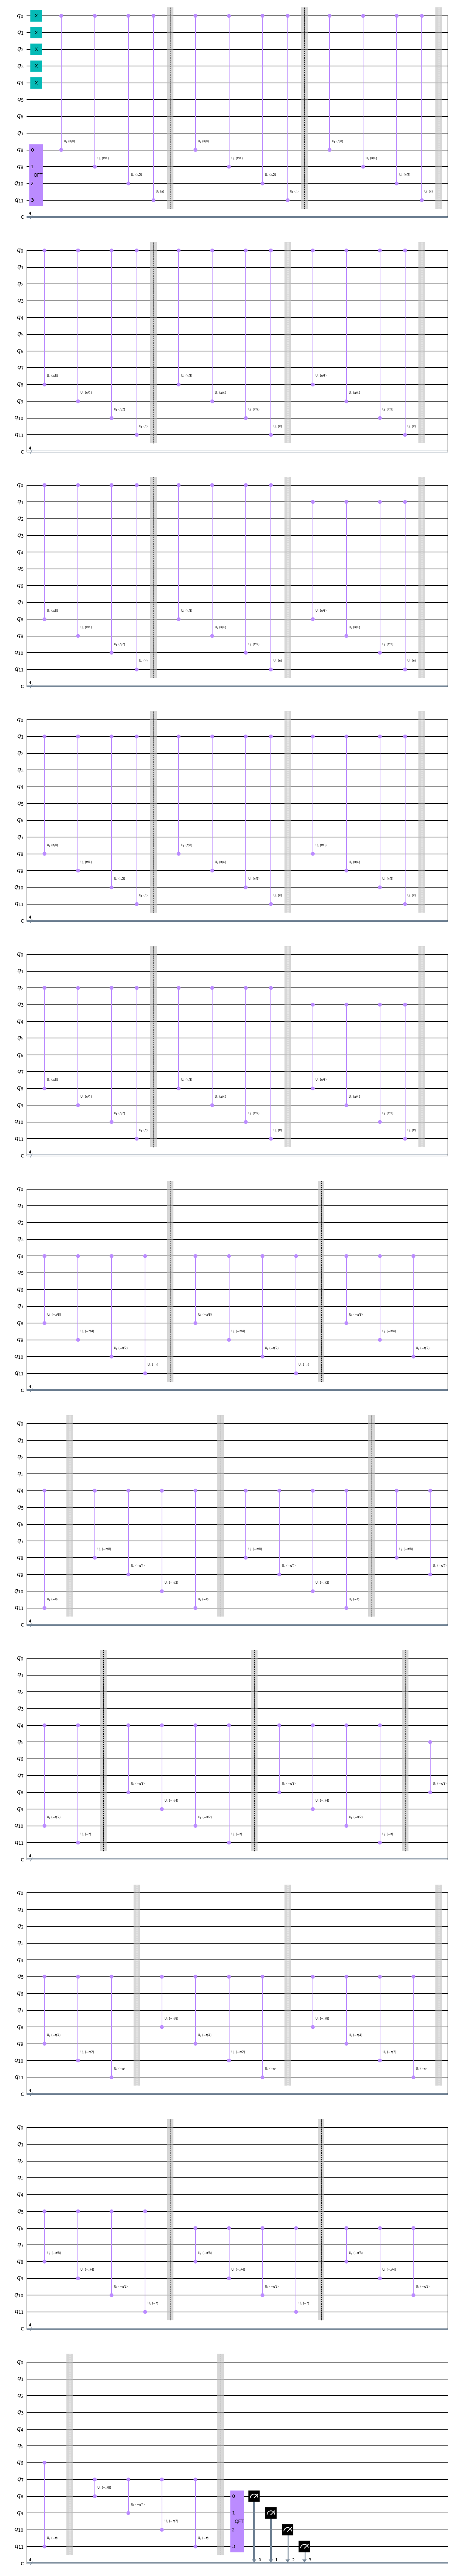

In [18]:
qc = QuantumCircuit(12,4)
# Pixel from the first image
qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
# ------------------------------
# ------------------------------
# ------------------------------
# Pixel from the second image
qc.x(4)

rotationsFourier(qc)

qc.measure(range(8,12), range(4))
#qc = qc.reverse_bits()
qc.draw('mpl')

In [5]:
qc.size()
qc.depth()

131

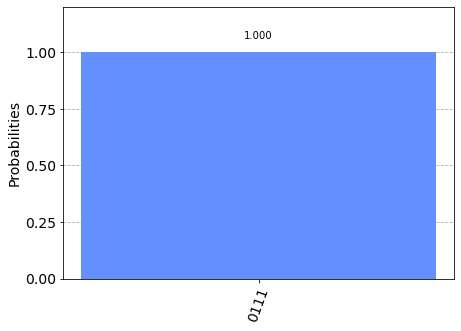

In [7]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots = 5)
plot_histogram(job.result().get_counts())


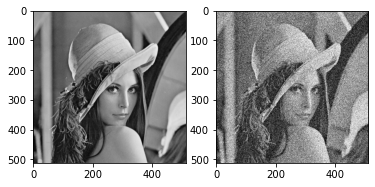

In [8]:
originalImage = cv2.imread('lena_gray.png')
grayOriginalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
noisyImage = cv2.imread('lena_gray_512_512_variance_400.png')
grayNoisyImage = cv2.cvtColor(noisyImage, cv2.COLOR_BGR2GRAY)
plt.subplot(1,2,1)
plt.imshow(grayOriginalImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(grayNoisyImage, cmap='gray')
plt.show()

Original Image Dimensions :  (512, 512)
Resized Original Image Dimensions :  (64, 64)
Resized Noisy Image Dimensions :  (64, 64)


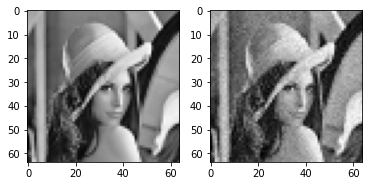

In [9]:
print('Original Image Dimensions : ',grayOriginalImage.shape) # Since images are 512x512 size
scale_percent = 12.5 # percent of original size for a 64x64 size
width = int(grayOriginalImage.shape[1] * scale_percent / 100)
height = int(grayOriginalImage.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize Original image
resizedOriginalImage = cv2.resize(grayOriginalImage, dim, interpolation = cv2.INTER_AREA)
print('Resized Original Image Dimensions : ',resizedOriginalImage.shape)
# resize Noisy image

resizedNoisyImage = cv2.resize(grayNoisyImage, dim, interpolation = cv2.INTER_AREA)
print('Resized Noisy Image Dimensions : ',resizedNoisyImage.shape)


plt.subplot(1,2,1)
plt.imshow(resizedOriginalImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(resizedNoisyImage, cmap='gray')
plt.show()

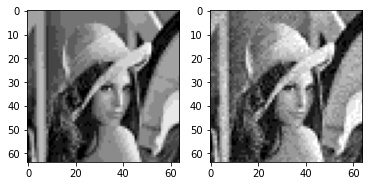

In [10]:
# Since we have a image of 8-bit pixel, make 256 rotations it not will be an option for a quantum circuit,
# so we use a 4-bit pixel from de 64x64 image
# originalImage64 = cv2.cvtColor(resizedOriginalImage, cv2.COLOR_BGR2GRAY) 
# noisyImage64 = cv2.cvtColor(resizedNoisyImage, cv2.COLOR_BGR2GRAY) 

[hight,lenght] = resizedOriginalImage.shape

# imagecopy= np.copy(grayimg64)
#Build an array for the original image 64*64
arrayOriginalImage = np.arange(0, 4096, 1, np.uint8)
arrayOriginalImage = np.reshape(arrayOriginalImage, (64, 64))

#CBuild an array for the noisy image de 64*64
arrayNoisyImage = np.arange(0, 4096, 1, np.uint8)
arrayNoisyImage = np.reshape(arrayNoisyImage, (64, 64))

for altura in range(0,hight):
    for ancho in range (0,lenght):
        arrayOriginalImage[altura,ancho] = int(resizedOriginalImage[altura,ancho]/17)
        arrayNoisyImage[altura,ancho] = int(resizedNoisyImage[altura,ancho]/17)        
        
plt.subplot(1,2,1)
plt.imshow(arrayOriginalImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(arrayNoisyImage, cmap='gray')
plt.show()

In [11]:
def DevuelveStringCompleto(longValue,strignValue):
    resta = longValue - len(strignValue)
    Ceros = ''
    if resta !=0:
        for i in range(0,resta):
            Ceros += '0'      
    return Ceros+strignValue

In [12]:
listaCircuits = []
for i in range (0,arrayOriginalImage.shape[0]):
    for j in range (0,arrayOriginalImage.shape[1]):
        binaryPixelOne = bin(int(arrayOriginalImage[i,j]))
        binaryPixelTwo = bin(int(arrayNoisyImage[i,j]))
        CompleteBinaryOne = DevuelveStringCompleto(4,binaryPixelOne[2:len(binaryPixelOne)])
        CompleteBinaryTwo = DevuelveStringCompleto(4,binaryPixelTwo[2:len(binaryPixelTwo)])
        valueBinaryOne = str(CompleteBinaryOne)
        valueBinaryOTwo = str(CompleteBinaryTwo)

# Pixeles from Fisrt Image
# ------------------------------
# ------------------------------
# ------------------------------
# ------------------------------
        qc = QuantumCircuit(13,5)
        for idx, px_value in enumerate(valueBinaryOne[::1]):
            if(px_value=='1'):
                qc.x(idx)
                
# Pixels from Second Image
# ------------------------------
# ------------------------------
# ------------------------------
# ------------------------------

        for idy, py_value in enumerate(valueBinaryOTwo[::1]):
            if(py_value=='1'):
                qc.x(idy+4)
        rotationsFourier(qc)
####
#### Condition for negative numbers
####
        if (int(arrayOriginalImage[i,j]) < int(arrayNoisyImage[i,j])) and (int(arrayOriginalImage[i,j]) - int(arrayNoisyImage[i,j]) != 0) :
            qc.x(12)
        qc.measure(range(8,13), range(5))
        listaCircuits.append(qc)
#qc.draw()

In [13]:
len(listaCircuits)

4096

In [14]:
backend = Aer.get_backend('qasm_simulator')
job = execute(listaCircuits, backend, shots = 5)
# plot_histogram(job.result().get_counts())

In [15]:
distance = 0
result_submissions = job.result()
for qc in listaCircuits:
    counts = result_submissions.get_counts(qc)
    number= list(counts)[0]
    if number[0] == '0':
        dec_number= int(number, 2)
    else:
        dec_number= int(number[1:len(number)], 2) - 16

    distance += (dec_number**2)
print(distance)

1235


In [16]:
dist = 0
for i in range(0,arrayOriginalImage.shape[0]):
    for j in range(0,arrayOriginalImage.shape[0]):
        number = (int(arrayOriginalImage[i,j])-int(arrayNoisyImage[i,j]))
        dist += number**2

dist

1235

## References:

[1] Goshtasby, A. Ardeshir. Image registration: Principles, tools and methods. Springer Science & Business Media, 2012.

[2] https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

[3] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).